<a href="https://colab.research.google.com/github/nasreenwarsilecturer/predicting-lung-cancer-with-knn/blob/main/predicting_lung_cancer_with_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns 


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive

Mounted at /content/gdrive


[[95  0  0]
 [ 0 88  9]
 [11  1 96]]
0.93


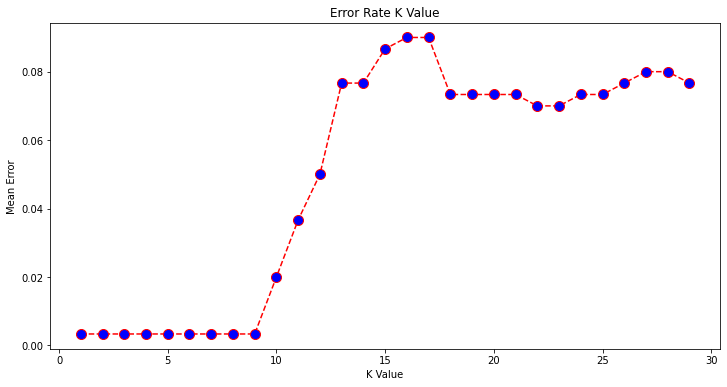

In [ ]:
# running KNN with out feature prediction
from sklearn.model_selection import KFold 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier 

cancerDataForKnn = pd.read_excel('/content/gdrive/MyDrive/Algo/cancer patient data sets.xlsx')

from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
cancerDataForKnn['Level'] = lb.fit_transform(cancerDataForKnn['Level']) # Change "Low" to 1 and "Medium" to 2 and "high" to 0 

x_train, x_test, y_train, y_test = train_test_split(cancerDataForKnn.drop(['Level','Patient Id'], axis = 1), cancerDataForKnn['Level'], test_size = 0.3)

x_train, x_test, y_train, y_test = train_test_split(cancerDataForKnn.drop(['Level','Patient Id'], axis = 1), 
                                                    cancerDataForKnn['Level'], test_size = 0.3)
# Experiment with n_neighbors = 23
knn = KNeighborsClassifier(n_neighbors = 23)
knn.fit(x_train,y_train)

y_pred = knn.predict(x_test)
print(confusion_matrix(y_test,y_pred))


print(accuracy_score(y_test, y_pred))


# Find an optimal number of neighbors with the lowest error rate 
error = []
for i in range(1,30): 
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(x_train, y_train)
    pred_i = knn.predict(x_test)
    error.append(np.mean(pred_i != y_test))
	

# plt.figure(figsize = (12,6))
# plt.plot(range(1,30), error)
# plt.xlabel("K Value")
# plt.ylabel("Mean Error")
# plt.show()	

plt.figure(figsize=(12, 6))
plt.plot(range(1, 30), error, color='red', linestyle='dashed', marker='o',
markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')
plt.show()	
	
	



In [ ]:
!pip install deap
!pip install scoop

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 KB 13.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.4/615.4 KB 33.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scoop: filename=scoop-0.7.2.0-py3-none-any.whl size=78119 sha256=ca429e60db62fa27b05cedb49ce8a6d650bbff62d889cc72e068a933eca035e6
  Stored in directory: /root/.cache/pip/wheels/06/d1/b8/b4495d80f3aa67a67b8d19a900892d4f6af3c6d1bdd3cd015c
Successfully built scoop


# New Section

In [ ]:
# feature selection using genetic algo
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from deap import creator, base, tools, algorithms
from scoop import futures
import random
import numpy
from scipy import interpolate
import matplotlib.pyplot as plt

# Read in data from CSV
dfData = pd.read_excel('/content/gdrive/MyDrive/Algo/cancer patient data sets.xlsx')

# Encode the classification labels to numbers
# Get classes and one hot encoded feature vectors
le = LabelEncoder()
le.fit(dfData['Level'])
allClasses = le.transform(dfData['Level'])
allFeatures = dfData.drop(['Level'], axis=1)

# Form training, test, and validation sets
X_trainAndTest, X_validation, y_trainAndTest, y_validation = train_test_split(allFeatures, allClasses, test_size=0.20,
                                                                              random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_trainAndTest, y_trainAndTest, test_size=0.20, random_state=42)


# Feature subset fitness function
def getFitness(individual, X_train, X_test, y_train, y_test):
    # Parse our feature columns that we don't use
    # Apply one hot encoding to the features
    cols = [index for index in range(len(individual)) if individual[index] == 0]
    X_trainParsed = X_train.drop(X_train.columns[cols], axis=1)
    X_trainOhFeatures = pd.get_dummies(X_trainParsed)
    X_testParsed = X_test.drop(X_test.columns[cols], axis=1)
    X_testOhFeatures = pd.get_dummies(X_testParsed)

    # Remove any columns that aren't in both the training and test sets
    sharedFeatures = set(X_trainOhFeatures.columns) & set(X_testOhFeatures.columns)
    removeFromTrain = set(X_trainOhFeatures.columns) - sharedFeatures
    removeFromTest = set(X_testOhFeatures.columns) - sharedFeatures
    X_trainOhFeatures = X_trainOhFeatures.drop(list(removeFromTrain), axis=1)
    X_testOhFeatures = X_testOhFeatures.drop(list(removeFromTest), axis=1)

    # Apply logistic regression on the data, and calculate accuracy
    clf = LogisticRegression()
    clf.fit(X_trainOhFeatures, y_train)
    predictions = clf.predict(X_testOhFeatures)
    accuracy = accuracy_score(y_test, predictions)

    # Return calculated accuracy as fitness
    return (accuracy,)


# ========DEAP GLOBAL VARIABLES (viewable by SCOOP)========

# Create Individual
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Create Toolbox
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, len(dfData.columns) - 1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Continue filling toolbox...
toolbox.register("evaluate", getFitness, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)


# ========

def getHof():
    # Initialize variables to use eaSimple
    numPop = 100
    numGen = 10
    pop = toolbox.population(n=numPop)
    hof = tools.HallOfFame(numPop * numGen)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("std", numpy.std)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)

    # Launch genetic algorithm
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=numGen, stats=stats, halloffame=hof,
                                   verbose=True)

    # Return the hall of fame
    return hof


def getMetrics(hof):
    # Get list of percentiles in the hall of fame
    percentileList = [i / (len(hof) - 1) for i in range(len(hof))]

    # Gather fitness data from each percentile
    testAccuracyList = []
    validationAccuracyList = []
    individualList = []
    for individual in hof:
        testAccuracy = individual.fitness.values
        validationAccuracy = getFitness(individual, X_trainAndTest, X_validation, y_trainAndTest, y_validation)
        testAccuracyList.append(testAccuracy[0])
        validationAccuracyList.append(validationAccuracy[0])
        individualList.append(individual)
    testAccuracyList.reverse()
    validationAccuracyList.reverse()
    return testAccuracyList, validationAccuracyList, individualList, percentileList


if __name__ == '__main__':

    '''
    First, we will apply logistic regression using all the features to acquire a baseline accuracy.
    '''
    individual = [1 for i in range(len(allFeatures.columns))]
    testAccuracy = getFitness(individual, X_train, X_test, y_train, y_test)
    validationAccuracy = getFitness(individual, X_trainAndTest, X_validation, y_trainAndTest, y_validation)
    print('\nTest accuracy with all features: \t' + str(testAccuracy[0]))
    print('Validation accuracy with all features: \t' + str(validationAccuracy[0]) + '\n')

    '''
    Now, we will apply a genetic algorithm to choose a subset of features that gives a better accuracy than the baseline.
    '''
    hof = getHof()
    testAccuracyList, validationAccuracyList, individualList, percentileList = getMetrics(hof)

    # Get a list of subsets that performed best on validation data
    maxValAccSubsetIndicies = [index for index in range(len(validationAccuracyList)) if
                               validationAccuracyList[index] == max(validationAccuracyList)]
    maxValIndividuals = [individualList[index] for index in maxValAccSubsetIndicies]
    maxValSubsets = [[list(allFeatures)[index] for index in range(len(individual)) if individual[index] == 1] for
                     individual in maxValIndividuals]

    print('\n---Optimal Feature Subset(s)---\n')
    for index in range(len(maxValAccSubsetIndicies)):
        print('Percentile: \t\t\t' + str(percentileList[maxValAccSubsetIndicies[index]]))
        print('Validation Accuracy: \t\t' + str(validationAccuracyList[maxValAccSubsetIndicies[index]]))
        print('Individual: \t' + str(maxValIndividuals[index]))
        print('Number Features In Subset: \t' + str(len(maxValSubsets[index])))
        print('Feature Subset: ' + str(maxValSubsets[index]))



/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che


Test accuracy with all features: 	0.98125
Validation accuracy with all features: 	0.995



/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

gen	nevals	avg  	std      	min    	max
0  	100   	0.947	0.0512384	0.70625	1  


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

1  	62    	0.98175	0.027623 	0.825  	1  


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

2  	65    	0.994375	0.0144292	0.93125	1  


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

3  	60    	0.999188	0.00456336	0.96875	1  


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

4  	52    	0.999125	0.00586435	0.95   	1  


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

5  	63    	0.998312	0.00814205	0.9375 	1  


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

6  	70    	0.998812	0.00513071	0.9625 	1  


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

7  	69    	0.998563	0.00749244	0.93125	1  


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

8  	53    	0.999437	0.00415472	0.9625 	1  


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

9  	46    	0.999   	0.00513262	0.95625	1  


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

10 	62    	0.999625	0.00194052	0.9875 	1  


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che


---Optimal Feature Subset(s)---

Percentile: 			0.09152542372881356
Validation Accuracy: 		1.0
Individual: 	[0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1]
Number Features In Subset: 	15
Feature Subset: ['Air Pollution', 'Alcohol use', 'Dust Allergy', 'Genetic Risk', 'chronic Lung Disease', 'Smoking', 'Passive Smoker', 'Chest Pain', 'Coughing of Blood', 'Fatigue', 'Weight Loss', 'Clubbing of Finger Nails', 'Frequent Cold', 'Dry Cough', 'Snoring']
Percentile: 			0.10508474576271186
Validation Accuracy: 		1.0
Individual: 	[1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1]
Number Features In Subset: 	16
Feature Subset: ['Patient Id', 'Gender', 'Air Pollution', 'Alcohol use', 'Dust Allergy', 'OccuPational Hazards', 'Smoking', 'Passive Smoker', 'Fatigue', 'Weight Loss', 'Shortness of Breath', 'Wheezing', 'Swallowing Difficulty', 'Clubbing of Finger Nails', 'Frequent Cold', 'Snoring']
Percentile: 			0.15084745762711865
Validation Accuracy: 		1.

<ipython-input-15-1cc78ae81c42>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancerDataForKnn['Level'] = lb.fit_transform(cancerDataForKnn['Level']) # Change "Low" to 1 and "Medium" to 2 and "high" to 0


[[107   0   0]
 [  0  91   1]
 [  0   1 100]]
0.9933333333333333


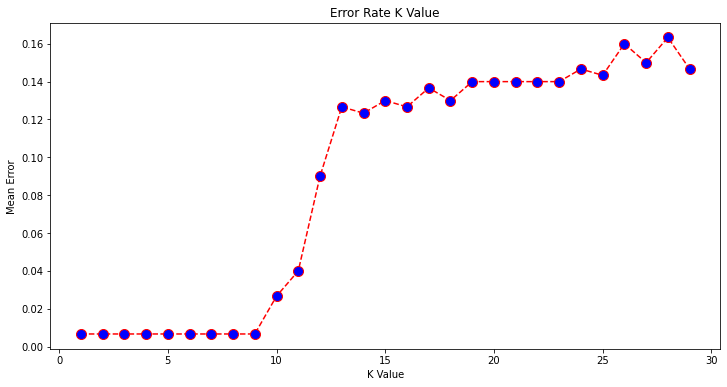

In [ ]:
from sklearn.model_selection import KFold 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier 

cancerData = pd.read_excel('/content/gdrive/MyDrive/Algo/cancer patient data sets.xlsx')
cancerDataForKnn = cancerData[['Age', 'Gender', 'Dust Allergy', 'Balanced Diet', 'Passive Smoker', 'Wheezing', 'Swallowing Difficulty', 'Level','Patient Id']]
cancerDataForKnn.head()


from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
cancerDataForKnn['Level'] = lb.fit_transform(cancerDataForKnn['Level']) # Change "Low" to 1 and "Medium" to 2 and "high" to 0 

x_train, x_test, y_train, y_test = train_test_split(cancerDataForKnn.drop(['Level','Patient Id'], axis = 1), cancerDataForKnn['Level'], test_size = 0.3)

x_train, x_test, y_train, y_test = train_test_split(cancerDataForKnn.drop(['Level','Patient Id'], axis = 1), 
                                                    cancerDataForKnn['Level'], test_size = 0.3)
# Experiment with n_neighbors = 7
knn = KNeighborsClassifier(n_neighbors = 7)
knn.fit(x_train,y_train)


y_pred = knn.predict(x_test)
print(confusion_matrix(y_test,y_pred))


print(accuracy_score(y_test, y_pred))


# Find an optimal number of neighbors with the lowest error rate 
error = []
for i in range(1,30): 
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(x_train, y_train)
    pred_i = knn.predict(x_test)
    error.append(np.mean(pred_i != y_test))
	

plt.figure(figsize=(12, 6))
plt.plot(range(1, 30), error, color='red', linestyle='dashed', marker='o',
markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')
plt.show()		
	
	



<ipython-input-46-de008e4ffc3a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancerDataForKnn['Level'] = lb.fit_transform(cancerDataForKnn['Level']) # Change "Low" to 1 and "Medium" to 2 and "high" to 0


Most participants in the dataset have lung cancer. Hence, they should exhibit at least one symptom for lung cancer. 

There is one outlier, a participant aged 20+. The age variable appears to follow a Gaussian distribution. 

The features fatigue and shortness of breath appear very imbalanced in its result.  

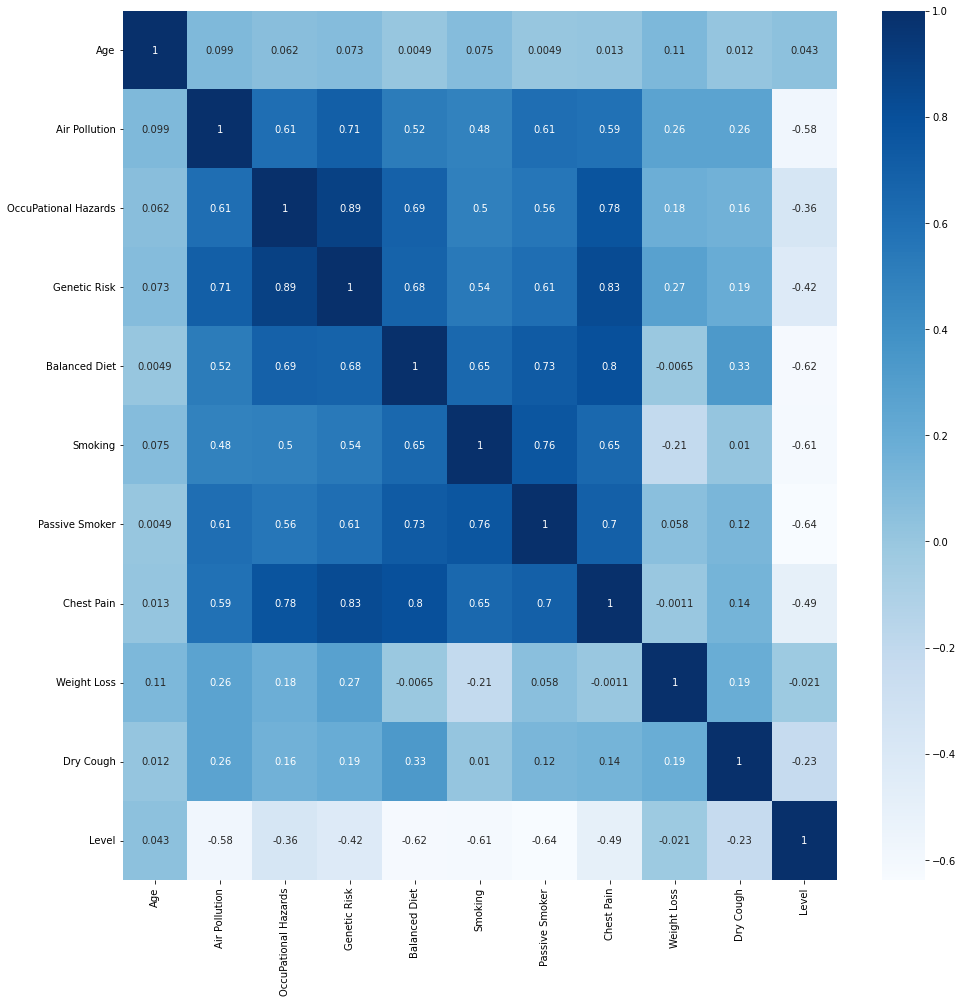

In [ ]:
plt.figure(figsize = (16,16))
sns.heatmap(cancerDataForKnn.corr(), annot = True, cmap = "Blues")

Features with the highest correlation to lung cancer: Alcohol consumption, swallowing difficulty, allergy, wheezing and coughing. 

As allergy is very vague, we ignore that allergy has a high correlation with lung cancer. 

Strangely, smoking has a low correlation with lung cancer. 

**Prediction Model - K Nearest Neighbor for Classification**

Thank you for reading my notebook. Please comment if you have any inputs on how to make my code or notebook better.